In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [5]:
# global variables

look_back = 21
lead_time = 180
filename = '../../../data/Arctic_domain_mean_1979_2018 - Curated.csv'
gc_features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall', 'snowfall', 'sosaline', 't2m', 'surface_pressure', 'sea_ice_extent']

In [6]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))
# df = df[7305:]
# df

# Reading the dataset
df = pd.read_csv(filename)
df = df[7305:]
df.head()

,Day,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
7305,1/1/1999,4.987515,0.891843,183.786092,1.120906,0.700735,0.501109,33.316996,273.467869,250.884060,985.112721,13823248
7306,1/2/1999,5.075952,0.905535,183.851814,1.193514,0.712730,0.482221,33.316996,273.453826,250.359328,984.092282,13885522
7307,1/3/1999,4.931520,0.911672,184.426913,1.263909,0.677339,0.480718,33.316996,273.454385,250.327500,982.300080,13884279
7308,1/4/1999,4.761644,0.911301,187.528326,1.269229,0.824016,0.697950,33.316996,273.459797,249.905730,983.250565,13912624
7309,1/5/1999,4.739850,0.901353,187.326709,1.552208,0.926681,0.835868,33.316996,273.463975,250.254873,984.247389,13890148


In [4]:
df['Day'] = pd.to_datetime(df['Day'], infer_datetime_format=True)
df.set_index('Day', inplace=True)
df = df.astype(float)                 # cast df to float
df = df[gc_features]
# df.tail(len(df))

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

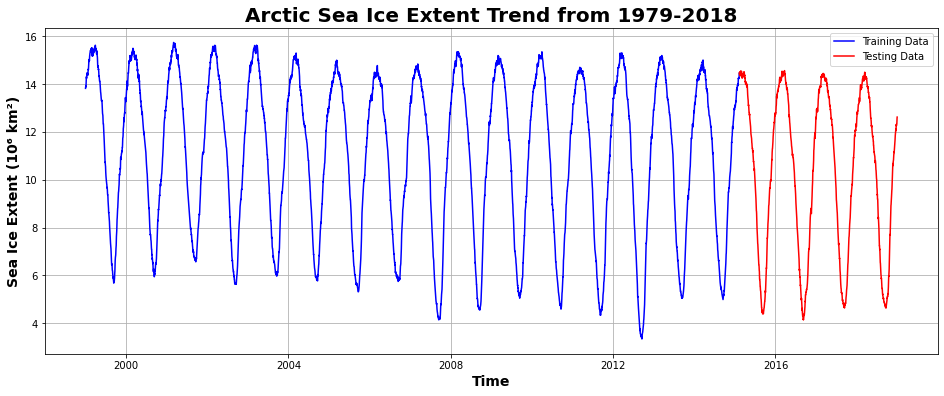

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 21, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 21, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 121,729
Trainable params: 121,729
Non-trai

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
78/80 [============================>.] - ETA: 0s - loss: 0.0324 - mae: 0.1282 - mse: 0.0324

80/80 [==============================] - 9s 19ms/step - loss: 0.0319 - mae: 0.1269 - mse: 0.0319 - val_loss: 0.0028 - val_mae: 0.0388 - val_mse: 0.0028
Epoch 2/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0084 - mae: 0.0709 - mse: 0.0084

80/80 [==============================] - 1s 8ms/step - loss: 0.0084 - mae: 0.0708 - mse: 0.0084 - val_loss: 0.0019 - val_mae: 0.0354 - val_mse: 0.0019
Epoch 3/100
78/80 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0652 - mse: 0.0072

80/80 [==============================] - 1s 9ms/step - loss: 0.0072 - mae: 0.0652 - mse: 0.0072 - val_loss: 0.0032 - val_mae: 0.0398 - val_mse: 0.0032
Epoch 4/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0063 - mae: 0.0611 - mse: 0.0063

80/80 [==============================] - 1s 8ms/step - loss: 0.0062 - mae: 0.0609 - mse: 0.0062 - val_loss: 0.0027 - val_mae: 0.0431 - val_mse: 0.0027
Epoch 5/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0056 - mae: 0.0582 - mse: 0.0056

80/80 [==============================] - 1s 9ms/step - loss: 0.0055 - mae: 0.0579 - mse: 0.0055 - val_loss: 9.5359e-04 - val_mae: 0.0230 - val_mse: 9.5359e-04
Epoch 6/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0046 - mae: 0.0523 - mse: 0.0046

80/80 [==============================] - 1s 8ms/step - loss: 0.0046 - mae: 0.0523 - mse: 0.0046 - val_loss: 0.0023 - val_mae: 0.0426 - val_mse: 0.0023
Epoch 7/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0043 - mae: 0.0508 - mse: 0.0043

80/80 [==============================] - 1s 8ms/step - loss: 0.0043 - mae: 0.0507 - mse: 0.0043 - val_loss: 0.0021 - val_mae: 0.0353 - val_mse: 0.0021
Epoch 8/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0042 - mae: 0.0506 - mse: 0.0042

80/80 [==============================] - 1s 9ms/step - loss: 0.0042 - mae: 0.0504 - mse: 0.0042 - val_loss: 0.0019 - val_mae: 0.0343 - val_mse: 0.0019
Epoch 9/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - mae: 0.0482 - mse: 0.0038

80/80 [==============================] - 1s 9ms/step - loss: 0.0038 - mae: 0.0483 - mse: 0.0038 - val_loss: 0.0011 - val_mae: 0.0264 - val_mse: 0.0011
Epoch 10/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - mae: 0.0484 - mse: 0.0038

80/80 [==============================] - 1s 9ms/step - loss: 0.0038 - mae: 0.0483 - mse: 0.0038 - val_loss: 0.0018 - val_mae: 0.0327 - val_mse: 0.0018
Epoch 11/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - mae: 0.0477 - mse: 0.0037

80/80 [==============================] - 1s 8ms/step - loss: 0.0036 - mae: 0.0477 - mse: 0.0036 - val_loss: 0.0014 - val_mae: 0.0298 - val_mse: 0.0014
Epoch 12/100
78/80 [============================>.] - ETA: 0s - loss: 0.0035 - mae: 0.0468 - mse: 0.0035

80/80 [==============================] - 1s 8ms/step - loss: 0.0035 - mae: 0.0467 - mse: 0.0035 - val_loss: 9.6930e-04 - val_mae: 0.0246 - val_mse: 9.6930e-04
Epoch 13/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - mae: 0.0445 - mse: 0.0032

80/80 [==============================] - 1s 9ms/step - loss: 0.0032 - mae: 0.0447 - mse: 0.0032 - val_loss: 9.9487e-04 - val_mae: 0.0247 - val_mse: 9.9487e-04
Epoch 14/100
80/80 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0446 - mse: 0.0033

80/80 [==============================] - 1s 9ms/step - loss: 0.0033 - mae: 0.0446 - mse: 0.0033 - val_loss: 8.7259e-04 - val_mae: 0.0227 - val_mse: 8.7259e-04
Epoch 15/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - mae: 0.0443 - mse: 0.0031

80/80 [==============================] - 1s 8ms/step - loss: 0.0031 - mae: 0.0442 - mse: 0.0031 - val_loss: 0.0040 - val_mae: 0.0457 - val_mse: 0.0040
Epoch 16/100
79/80 [============================>.] - ETA: 0s - loss: 0.0033 - mae: 0.0452 - mse: 0.0033

80/80 [==============================] - 1s 8ms/step - loss: 0.0033 - mae: 0.0452 - mse: 0.0033 - val_loss: 0.0020 - val_mae: 0.0360 - val_mse: 0.0020
Epoch 17/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0029 - mae: 0.0421 - mse: 0.0029

80/80 [==============================] - 1s 8ms/step - loss: 0.0029 - mae: 0.0421 - mse: 0.0029 - val_loss: 0.0022 - val_mae: 0.0351 - val_mse: 0.0022
Epoch 18/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0029 - mae: 0.0428 - mse: 0.0029

80/80 [==============================] - 1s 8ms/step - loss: 0.0029 - mae: 0.0425 - mse: 0.0029 - val_loss: 0.0021 - val_mae: 0.0318 - val_mse: 0.0021
Epoch 19/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - mae: 0.0435 - mse: 0.0030

80/80 [==============================] - 1s 8ms/step - loss: 0.0030 - mae: 0.0435 - mse: 0.0030 - val_loss: 0.0023 - val_mae: 0.0396 - val_mse: 0.0023
Epoch 20/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0027 - mae: 0.0410 - mse: 0.0027

80/80 [==============================] - 1s 8ms/step - loss: 0.0027 - mae: 0.0412 - mse: 0.0027 - val_loss: 0.0011 - val_mae: 0.0251 - val_mse: 0.0011
Epoch 21/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0393 - mse: 0.0025

80/80 [==============================] - 1s 9ms/step - loss: 0.0025 - mae: 0.0393 - mse: 0.0025 - val_loss: 0.0014 - val_mae: 0.0288 - val_mse: 0.0014
Epoch 22/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0417 - mse: 0.0028

80/80 [==============================] - 1s 8ms/step - loss: 0.0028 - mae: 0.0418 - mse: 0.0028 - val_loss: 0.0014 - val_mae: 0.0284 - val_mse: 0.0014
Epoch 23/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0028 - mae: 0.0415 - mse: 0.0028

80/80 [==============================] - 1s 9ms/step - loss: 0.0028 - mae: 0.0415 - mse: 0.0028 - val_loss: 0.0019 - val_mae: 0.0333 - val_mse: 0.0019
Epoch 24/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0026 - mae: 0.0404 - mse: 0.0026

80/80 [==============================] - 1s 9ms/step - loss: 0.0026 - mae: 0.0402 - mse: 0.0026 - val_loss: 0.0019 - val_mae: 0.0346 - val_mse: 0.0019
Epoch 25/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0393 - mse: 0.0025

80/80 [==============================] - 1s 8ms/step - loss: 0.0025 - mae: 0.0394 - mse: 0.0025 - val_loss: 0.0030 - val_mae: 0.0393 - val_mse: 0.0030
Epoch 26/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0376 - mse: 0.0023

80/80 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0376 - mse: 0.0023 - val_loss: 0.0018 - val_mae: 0.0306 - val_mse: 0.0018
Epoch 27/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0025 - mae: 0.0394 - mse: 0.0025

80/80 [==============================] - 1s 9ms/step - loss: 0.0025 - mae: 0.0394 - mse: 0.0025 - val_loss: 0.0015 - val_mae: 0.0308 - val_mse: 0.0015
Epoch 28/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0372 - mse: 0.0022

80/80 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0372 - mse: 0.0022 - val_loss: 0.0018 - val_mae: 0.0342 - val_mse: 0.0018
Epoch 29/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0022 - mae: 0.0368 - mse: 0.0022

80/80 [==============================] - 1s 9ms/step - loss: 0.0022 - mae: 0.0368 - mse: 0.0022 - val_loss: 0.0020 - val_mae: 0.0342 - val_mse: 0.0020
Epoch 30/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0366 - mse: 0.0022

80/80 [==============================] - 1s 9ms/step - loss: 0.0022 - mae: 0.0365 - mse: 0.0022 - val_loss: 0.0032 - val_mae: 0.0426 - val_mse: 0.0032
Epoch 31/100
78/80 [============================>.] - ETA: 0s - loss: 0.0023 - mae: 0.0375 - mse: 0.0023

80/80 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0375 - mse: 0.0023 - val_loss: 0.0024 - val_mae: 0.0397 - val_mse: 0.0024
Epoch 32/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0371 - mse: 0.0023

80/80 [==============================] - 1s 8ms/step - loss: 0.0023 - mae: 0.0374 - mse: 0.0023 - val_loss: 0.0021 - val_mae: 0.0386 - val_mse: 0.0021
Epoch 33/100
78/80 [============================>.] - ETA: 0s - loss: 0.0022 - mae: 0.0365 - mse: 0.0022

80/80 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0365 - mse: 0.0022 - val_loss: 0.0017 - val_mae: 0.0352 - val_mse: 0.0017
Epoch 34/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0366 - mse: 0.0022

80/80 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0368 - mse: 0.0022 - val_loss: 0.0017 - val_mae: 0.0350 - val_mse: 0.0017
Epoch 35/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0367 - mse: 0.0022

80/80 [==============================] - 1s 8ms/step - loss: 0.0022 - mae: 0.0366 - mse: 0.0022 - val_loss: 0.0028 - val_mae: 0.0421 - val_mse: 0.0028
Epoch 36/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0352 - mse: 0.0021

80/80 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0353 - mse: 0.0021 - val_loss: 0.0024 - val_mae: 0.0362 - val_mse: 0.0024
Epoch 37/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0363 - mse: 0.0021

80/80 [==============================] - 1s 8ms/step - loss: 0.0021 - mae: 0.0362 - mse: 0.0021 - val_loss: 0.0030 - val_mae: 0.0434 - val_mse: 0.0030
Epoch 38/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0345 - mse: 0.0019

80/80 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0344 - mse: 0.0019 - val_loss: 0.0032 - val_mae: 0.0472 - val_mse: 0.0032
Epoch 39/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0339 - mse: 0.0019

80/80 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0341 - mse: 0.0019 - val_loss: 0.0033 - val_mae: 0.0478 - val_mse: 0.0033
Epoch 40/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0339 - mse: 0.0019

80/80 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0339 - mse: 0.0019 - val_loss: 0.0030 - val_mae: 0.0461 - val_mse: 0.0030
Epoch 41/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0335 - mse: 0.0018

80/80 [==============================] - 1s 9ms/step - loss: 0.0018 - mae: 0.0336 - mse: 0.0018 - val_loss: 0.0023 - val_mae: 0.0392 - val_mse: 0.0023
Epoch 42/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0329 - mse: 0.0018

80/80 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0329 - mse: 0.0018 - val_loss: 0.0032 - val_mae: 0.0457 - val_mse: 0.0032
Epoch 43/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0332 - mse: 0.0018

80/80 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0332 - mse: 0.0018 - val_loss: 0.0022 - val_mae: 0.0330 - val_mse: 0.0022
Epoch 44/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0018 - mae: 0.0327 - mse: 0.0018

80/80 [==============================] - 1s 8ms/step - loss: 0.0018 - mae: 0.0327 - mse: 0.0018 - val_loss: 0.0022 - val_mae: 0.0367 - val_mse: 0.0022
Epoch 45/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0018 - mae: 0.0329 - mse: 0.0018

80/80 [==============================] - 1s 9ms/step - loss: 0.0018 - mae: 0.0327 - mse: 0.0018 - val_loss: 0.0028 - val_mae: 0.0455 - val_mse: 0.0028
Epoch 46/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0019 - mae: 0.0337 - mse: 0.0019

80/80 [==============================] - 1s 8ms/step - loss: 0.0019 - mae: 0.0335 - mse: 0.0019 - val_loss: 0.0030 - val_mae: 0.0467 - val_mse: 0.0030
Epoch 47/100
78/80 [============================>.] - ETA: 0s - loss: 0.0016 - mae: 0.0314 - mse: 0.0016

80/80 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0313 - mse: 0.0016 - val_loss: 0.0019 - val_mae: 0.0340 - val_mse: 0.0019
Epoch 48/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0319 - mse: 0.0017

80/80 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0319 - mse: 0.0017 - val_loss: 0.0028 - val_mae: 0.0425 - val_mse: 0.0028
Epoch 49/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0308 - mse: 0.0015

80/80 [==============================] - 1s 8ms/step - loss: 0.0016 - mae: 0.0310 - mse: 0.0016 - val_loss: 0.0043 - val_mae: 0.0479 - val_mse: 0.0043
Epoch 50/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0308 - mse: 0.0015

80/80 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0309 - mse: 0.0015 - val_loss: 0.0029 - val_mae: 0.0455 - val_mse: 0.0029
Epoch 51/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0017 - mae: 0.0318 - mse: 0.0017

80/80 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0320 - mse: 0.0017 - val_loss: 0.0035 - val_mae: 0.0520 - val_mse: 0.0035
Epoch 52/100
78/80 [============================>.] - ETA: 0s - loss: 0.0017 - mae: 0.0321 - mse: 0.0017

80/80 [==============================] - 1s 8ms/step - loss: 0.0017 - mae: 0.0321 - mse: 0.0017 - val_loss: 0.0028 - val_mae: 0.0459 - val_mse: 0.0028
Epoch 53/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0300 - mse: 0.0015

80/80 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0029 - val_mae: 0.0423 - val_mse: 0.0029
Epoch 54/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0289 - mse: 0.0014

80/80 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0288 - mse: 0.0014 - val_loss: 0.0035 - val_mae: 0.0526 - val_mse: 0.0035
Epoch 55/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0301 - mse: 0.0015

80/80 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0043 - val_mae: 0.0564 - val_mse: 0.0043
Epoch 56/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0303 - mse: 0.0015

80/80 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - val_loss: 0.0025 - val_mae: 0.0416 - val_mse: 0.0025
Epoch 57/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0291 - mse: 0.0014

80/80 [==============================] - 1s 9ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 0.0037 - val_mae: 0.0522 - val_mse: 0.0037
Epoch 58/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0301 - mse: 0.0015

80/80 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0034 - val_mae: 0.0484 - val_mse: 0.0034
Epoch 59/100
79/80 [============================>.] - ETA: 0s - loss: 0.0014 - mae: 0.0292 - mse: 0.0014

80/80 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 0.0022 - val_mae: 0.0377 - val_mse: 0.0022
Epoch 60/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0298 - mse: 0.0015

80/80 [==============================] - 1s 9ms/step - loss: 0.0015 - mae: 0.0299 - mse: 0.0015 - val_loss: 0.0037 - val_mae: 0.0487 - val_mse: 0.0037
Epoch 61/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0015 - mae: 0.0302 - mse: 0.0015

80/80 [==============================] - 1s 8ms/step - loss: 0.0015 - mae: 0.0300 - mse: 0.0015 - val_loss: 0.0032 - val_mae: 0.0508 - val_mse: 0.0032
Epoch 62/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0013 - mae: 0.0282 - mse: 0.0013

80/80 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0281 - mse: 0.0013 - val_loss: 0.0043 - val_mae: 0.0555 - val_mse: 0.0043
Epoch 63/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0293 - mse: 0.0014

80/80 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0294 - mse: 0.0014 - val_loss: 0.0034 - val_mae: 0.0517 - val_mse: 0.0034
Epoch 64/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0277 - mse: 0.0012

80/80 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0278 - mse: 0.0012 - val_loss: 0.0034 - val_mae: 0.0503 - val_mse: 0.0034
Epoch 65/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0281 - mse: 0.0013

80/80 [==============================] - 1s 9ms/step - loss: 0.0013 - mae: 0.0279 - mse: 0.0013 - val_loss: 0.0033 - val_mae: 0.0476 - val_mse: 0.0033
Epoch 66/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0263 - mse: 0.0011

80/80 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0263 - mse: 0.0011 - val_loss: 0.0029 - val_mae: 0.0452 - val_mse: 0.0029
Epoch 67/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0013 - mae: 0.0278 - mse: 0.0013

80/80 [==============================] - 1s 8ms/step - loss: 0.0013 - mae: 0.0280 - mse: 0.0013 - val_loss: 0.0030 - val_mae: 0.0414 - val_mse: 0.0030
Epoch 68/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0276 - mse: 0.0012

80/80 [==============================] - 1s 8ms/step - loss: 0.0012 - mae: 0.0274 - mse: 0.0012 - val_loss: 0.0033 - val_mae: 0.0485 - val_mse: 0.0033
Epoch 69/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0010 - mae: 0.0255 - mse: 0.0010

80/80 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0024 - val_mae: 0.0399 - val_mse: 0.0024
Epoch 70/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0293 - mse: 0.0014

80/80 [==============================] - 1s 8ms/step - loss: 0.0014 - mae: 0.0292 - mse: 0.0014 - val_loss: 0.0028 - val_mae: 0.0431 - val_mse: 0.0028
Epoch 71/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0012 - mae: 0.0271 - mse: 0.0012

80/80 [==============================] - 1s 9ms/step - loss: 0.0012 - mae: 0.0269 - mse: 0.0012 - val_loss: 0.0026 - val_mae: 0.0442 - val_mse: 0.0026
Epoch 72/100
76/80 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0256 - mse: 0.0011

80/80 [==============================] - 1s 8ms/step - loss: 0.0011 - mae: 0.0256 - mse: 0.0011 - val_loss: 0.0034 - val_mae: 0.0514 - val_mse: 0.0034
Epoch 73/100
78/80 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0251 - mse: 0.0010

80/80 [==============================] - 1s 8ms/step - loss: 9.9879e-04 - mae: 0.0251 - mse: 9.9879e-04 - val_loss: 0.0028 - val_mae: 0.0445 - val_mse: 0.0028
Epoch 74/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0263 - mse: 0.0011

80/80 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0263 - mse: 0.0011 - val_loss: 0.0031 - val_mae: 0.0465 - val_mse: 0.0031
Epoch 75/100
75/80 [===========================>..] - ETA: 0s - loss: 9.9584e-04 - mae: 0.0248 - mse: 9.9584e-04

80/80 [==============================] - 1s 9ms/step - loss: 9.8477e-04 - mae: 0.0247 - mse: 9.8477e-04 - val_loss: 0.0027 - val_mae: 0.0448 - val_mse: 0.0027
Epoch 76/100
76/80 [===========================>..] - ETA: 0s - loss: 9.8916e-04 - mae: 0.0248 - mse: 9.8916e-04

80/80 [==============================] - 1s 8ms/step - loss: 9.8248e-04 - mae: 0.0247 - mse: 9.8248e-04 - val_loss: 0.0028 - val_mae: 0.0430 - val_mse: 0.0028
Epoch 77/100
78/80 [============================>.] - ETA: 0s - loss: 9.8104e-04 - mae: 0.0247 - mse: 9.8104e-04

80/80 [==============================] - 1s 8ms/step - loss: 9.7532e-04 - mae: 0.0246 - mse: 9.7532e-04 - val_loss: 0.0041 - val_mae: 0.0571 - val_mse: 0.0041
Epoch 78/100
75/80 [===========================>..] - ETA: 0s - loss: 0.0011 - mae: 0.0261 - mse: 0.0011

80/80 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0260 - mse: 0.0011 - val_loss: 0.0032 - val_mae: 0.0497 - val_mse: 0.0032
Epoch 79/100
77/80 [===========================>..] - ETA: 0s - loss: 9.8552e-04 - mae: 0.0247 - mse: 9.8552e-04

80/80 [==============================] - 1s 8ms/step - loss: 9.9472e-04 - mae: 0.0248 - mse: 9.9472e-04 - val_loss: 0.0032 - val_mae: 0.0433 - val_mse: 0.0032
Epoch 80/100
78/80 [============================>.] - ETA: 0s - loss: 0.0010 - mae: 0.0252 - mse: 0.0010

80/80 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0032 - val_mae: 0.0474 - val_mse: 0.0032
Epoch 81/100
77/80 [===========================>..] - ETA: 0s - loss: 0.0010 - mae: 0.0252 - mse: 0.0010

80/80 [==============================] - 1s 8ms/step - loss: 0.0010 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0028 - val_mae: 0.0399 - val_mse: 0.0028
Epoch 82/100
80/80 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0259 - mse: 0.0011

80/80 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 0.0023 - val_mae: 0.0390 - val_mse: 0.0023
Epoch 83/100
76/80 [===========================>..] - ETA: 0s - loss: 8.4750e-04 - mae: 0.0231 - mse: 8.4750e-04

80/80 [==============================] - 1s 8ms/step - loss: 8.4593e-04 - mae: 0.0230 - mse: 8.4593e-04 - val_loss: 0.0021 - val_mae: 0.0374 - val_mse: 0.0021
Epoch 84/100
75/80 [===========================>..] - ETA: 0s - loss: 7.7729e-04 - mae: 0.0221 - mse: 7.7729e-04

80/80 [==============================] - 1s 9ms/step - loss: 7.8166e-04 - mae: 0.0221 - mse: 7.8166e-04 - val_loss: 0.0032 - val_mae: 0.0485 - val_mse: 0.0032
Epoch 85/100
79/80 [============================>.] - ETA: 0s - loss: 9.8970e-04 - mae: 0.0248 - mse: 9.8970e-04

80/80 [==============================] - 1s 9ms/step - loss: 9.8951e-04 - mae: 0.0248 - mse: 9.8951e-04 - val_loss: 0.0026 - val_mae: 0.0419 - val_mse: 0.0026
Epoch 86/100
78/80 [============================>.] - ETA: 0s - loss: 8.6723e-04 - mae: 0.0233 - mse: 8.6723e-04

80/80 [==============================] - 1s 8ms/step - loss: 8.6992e-04 - mae: 0.0233 - mse: 8.6992e-04 - val_loss: 0.0029 - val_mae: 0.0465 - val_mse: 0.0029
Epoch 87/100
75/80 [===========================>..] - ETA: 0s - loss: 9.3578e-04 - mae: 0.0242 - mse: 9.3578e-04

80/80 [==============================] - 1s 8ms/step - loss: 9.3903e-04 - mae: 0.0242 - mse: 9.3903e-04 - val_loss: 0.0019 - val_mae: 0.0359 - val_mse: 0.0019
Epoch 88/100
74/80 [==========================>...] - ETA: 0s - loss: 0.0011 - mae: 0.0260 - mse: 0.0011

80/80 [==============================] - 1s 9ms/step - loss: 0.0011 - mae: 0.0259 - mse: 0.0011 - val_loss: 0.0026 - val_mae: 0.0427 - val_mse: 0.0026
Epoch 89/100
79/80 [============================>.] - ETA: 0s - loss: 8.3545e-04 - mae: 0.0227 - mse: 8.3545e-04

80/80 [==============================] - 1s 8ms/step - loss: 8.3618e-04 - mae: 0.0227 - mse: 8.3618e-04 - val_loss: 0.0029 - val_mae: 0.0465 - val_mse: 0.0029
Epoch 90/100
80/80 [==============================] - ETA: 0s - loss: 7.4363e-04 - mae: 0.0216 - mse: 7.4363e-04

80/80 [==============================] - 1s 9ms/step - loss: 7.4363e-04 - mae: 0.0216 - mse: 7.4363e-04 - val_loss: 0.0032 - val_mae: 0.0487 - val_mse: 0.0032
Epoch 91/100
75/80 [===========================>..] - ETA: 0s - loss: 8.3095e-04 - mae: 0.0226 - mse: 8.3095e-04

80/80 [==============================] - 1s 9ms/step - loss: 8.2585e-04 - mae: 0.0225 - mse: 8.2585e-04 - val_loss: 0.0031 - val_mae: 0.0447 - val_mse: 0.0031
Epoch 92/100
76/80 [===========================>..] - ETA: 0s - loss: 7.7274e-04 - mae: 0.0221 - mse: 7.7274e-04

80/80 [==============================] - 1s 8ms/step - loss: 7.7037e-04 - mae: 0.0220 - mse: 7.7037e-04 - val_loss: 0.0020 - val_mae: 0.0373 - val_mse: 0.0020
Epoch 93/100
80/80 [==============================] - ETA: 0s - loss: 7.5954e-04 - mae: 0.0217 - mse: 7.5954e-04

80/80 [==============================] - 1s 10ms/step - loss: 7.5954e-04 - mae: 0.0217 - mse: 7.5954e-04 - val_loss: 0.0025 - val_mae: 0.0434 - val_mse: 0.0025
Epoch 94/100
79/80 [============================>.] - ETA: 0s - loss: 7.5667e-04 - mae: 0.0217 - mse: 7.5667e-04

80/80 [==============================] - 1s 12ms/step - loss: 7.5784e-04 - mae: 0.0218 - mse: 7.5784e-04 - val_loss: 0.0034 - val_mae: 0.0501 - val_mse: 0.0034
Epoch 95/100
78/80 [============================>.] - ETA: 0s - loss: 7.1927e-04 - mae: 0.0211 - mse: 7.1927e-04

80/80 [==============================] - 1s 11ms/step - loss: 7.1714e-04 - mae: 0.0211 - mse: 7.1714e-04 - val_loss: 0.0025 - val_mae: 0.0424 - val_mse: 0.0025
Epoch 96/100
75/80 [===========================>..] - ETA: 0s - loss: 6.4882e-04 - mae: 0.0202 - mse: 6.4882e-04

80/80 [==============================] - 1s 10ms/step - loss: 6.5754e-04 - mae: 0.0203 - mse: 6.5754e-04 - val_loss: 0.0043 - val_mae: 0.0542 - val_mse: 0.0043
Epoch 97/100
80/80 [==============================] - ETA: 0s - loss: 7.6965e-04 - mae: 0.0219 - mse: 7.6965e-04

80/80 [==============================] - 1s 9ms/step - loss: 7.6965e-04 - mae: 0.0219 - mse: 7.6965e-04 - val_loss: 0.0022 - val_mae: 0.0392 - val_mse: 0.0022
Epoch 98/100
76/80 [===========================>..] - ETA: 0s - loss: 8.2371e-04 - mae: 0.0224 - mse: 8.2371e-04

80/80 [==============================] - 1s 8ms/step - loss: 8.3923e-04 - mae: 0.0225 - mse: 8.3923e-04 - val_loss: 0.0021 - val_mae: 0.0372 - val_mse: 0.0021
Epoch 99/100
74/80 [==========================>...] - ETA: 0s - loss: 7.6671e-04 - mae: 0.0218 - mse: 7.6671e-04

80/80 [==============================] - 1s 9ms/step - loss: 7.6925e-04 - mae: 0.0218 - mse: 7.6925e-04 - val_loss: 0.0034 - val_mae: 0.0491 - val_mse: 0.0034
Epoch 100/100
80/80 [==============================] - ETA: 0s - loss: 7.6708e-04 - mae: 0.0219 - mse: 7.6708e-04

80/80 [==============================] - 1s 9ms/step - loss: 7.6708e-04 - mae: 0.0219 - mse: 7.6708e-04 - val_loss: 0.0024 - val_mae: 0.0406 - val_mse: 0.0024


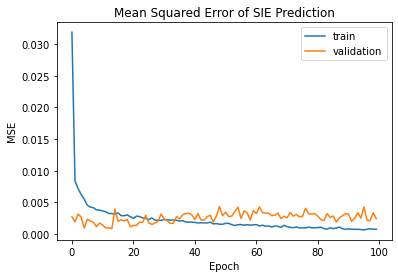

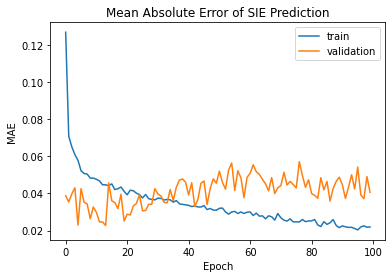

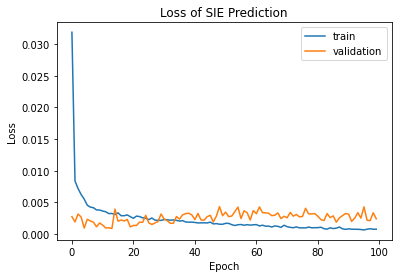

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

45/45 [==============================] - 1s 4ms/step


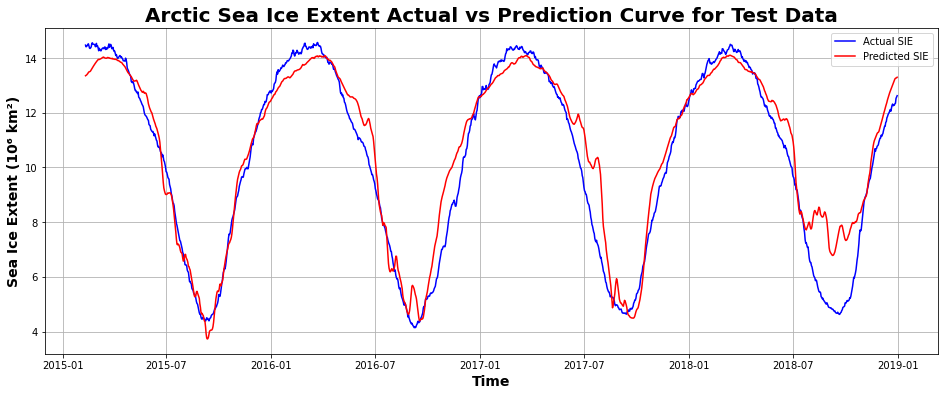

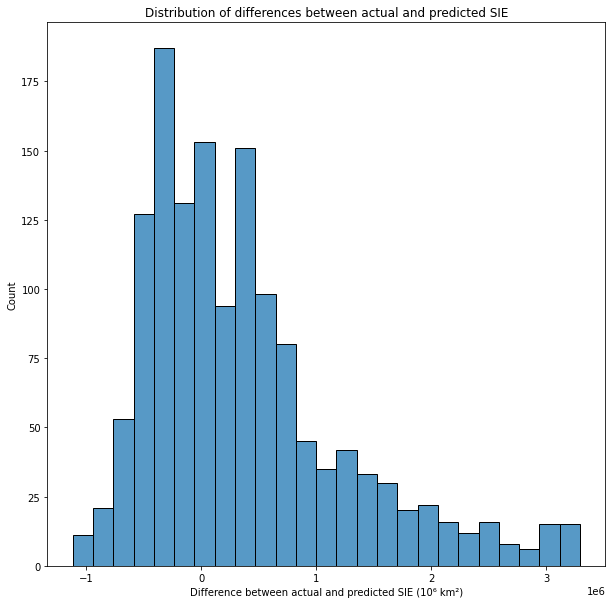

MSE :  899717804418.7839 (10⁶ km²)
MSPE : 2.2614630277122862 %
RMSE :  948534.5562596989 (10⁶ km²)
RMSPE : 15.03816154891377 %
MAE :  664304.6111893033 (10⁶ km²)
MAPE :  7.2102959621189395 %
R2 :  0.9014639954652595


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", mspe, "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", rmspe, "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100, "%")
print("R2 : ", r2_score(predictions['predicted'].values, predictions['actual'].values))

In [14]:
# while True:pass